In [10]:
import pandas as pd
import numpy as np

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
from sklearn.model_selection import StratifiedKFold, ParameterGrid
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from logging import StreamHandler, DEBUG, Formatter, FileHandler, getLogger
from tqdm import tqdm

- pathの指定

In [13]:
inpath = '../input/'
logpath = '../log/'

- 読み込み

In [14]:
train = pd.read_csv(inpath + 'train_small.csv')

In [15]:
# train.to_feather()

- make_features

In [16]:
train = train[['app', 'device', 'os', 'channel', 'is_attributed']]

In [17]:
x_train = train[['app', 'device', 'os', 'channel']]
y_train = train[ 'is_attributed'].values.astype(np.float32)

- learning

In [18]:
logger = getLogger(__name__)
log_fmt = Formatter('%(asctime)s %(name)s %(lineno)d [%(levelname)s][%(funcName)s] %(message)s ')
handler = StreamHandler()
handler.setLevel('INFO')
handler.setFormatter(log_fmt)
logger.addHandler(handler)

handler = FileHandler(logpath + 'train.py.log', 'a')
handler.setLevel(DEBUG)
handler.setFormatter(log_fmt)
logger.setLevel(DEBUG)
logger.addHandler(handler)

logger.info('start')

2018-05-27 13:37:39,870 __main__ 14 [INFO][<module>] start 


- CV設定
- CAT_FEATを指定

In [19]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=871)
all_params = {'min_child_weight': [25],
                  'subsample': [0.7],
                  'subsample_freq': [1],
                  'seed': [114],
                  'colsample_bytree': [0.6],
                  'learning_rate': [0.1],
                  'max_depth': [-1],
                  'min_split_gain': [0.001],
                  'reg_alpha': [0.0001],
                  'max_bin': [2047],
                  'num_leaves': [127],
                  'objective': ['binary'],
                  'metric': [ 'auc'],
                  'scale_pos_weight': [1],
                  'verbose': [-1],
                 }
CAT_FEAT = ['app', 'os']
FEAT_NAME = ['app', 'device', 'os', 'channel']

- GridSearch
- CVしてAUCの平均を求める
- STACKING　and FEEDBACK用のデータ出力

In [22]:
max_score = 0
max_params = None
for params in tqdm(list(ParameterGrid(all_params))):
    logger.info('params: {}'.format(params))
    list_auc_score = []
    list_best_iterations = []
    feedback_dic = {}
    for train_idx, valid_idx in cv.split(x_train, y_train):
        trn_x = x_train.iloc[train_idx, :]
        val_x = x_train.iloc[valid_idx, :]

        trn_y = y_train[train_idx]
        val_y = y_train[valid_idx]
        
        train_data = lgb.Dataset(trn_x.values.astype(np.float32), label=trn_y,
                                     categorical_feature=CAT_FEAT, feature_name=FEAT_NAME)
        valid_data = lgb.Dataset(val_x.values.astype(np.float32), label=val_y,
                                    categorical_feature=CAT_FEAT, feature_name=FEAT_NAME)

        clf = lgb.train(params,
                            train_data,
                            10000,  # params['n_estimators'],
                            early_stopping_rounds=30,
                            valid_sets=[valid_data],
                            # feval=cst_metric_xgb,
                            # callbacks=[callback],
                            verbose_eval=10
                            )
        
        pred = clf.predict(val_x)
        sc_auc = roc_auc_score(val_y, pred)
        
        stack_dic = dict(zip(valid_idx, pred))
        feedback_dic.update(stack_dic)

        list_auc_score.append(sc_auc)
        list_best_iterations.append(clf.best_iteration)
        logger.debug('   AUC: {}'.format(sc_auc))

    params['n_estimators'] = int(np.mean(list_best_iterations))
    sc_auc = np.mean(list_auc_score)
    logger.info('AUC {}'.format(sc_auc))
    if max_score < sc_auc:
        max_score = sc_auc
        max_params = params
    logger.info('current max score: {}, params: {}'.format(max_score, max_params))
    
    feedback_df = pd.DataFrame(pd.Series(feedback_dic), columns=['pred']).reset_index()
    feedback_df.to_csv('feedback.csv', index=False)

logger.info('max params: {}'.format(max_params))
logger.info('max AUC: {}'.format(max_score))

  0%|          | 0/1 [00:00<?, ?it/s]2018-05-27 13:38:02,505 __main__ 4 [INFO][<module>] params: {'seed': 114, 'max_depth': -1, 'reg_alpha': 0.0001, 'objective': 'binary', 'min_split_gain': 0.001, 'max_bin': 2047, 'learning_rate': 0.1, 'verbose': -1, 'subsample': 0.7, 'num_leaves': 127, 'metric': 'auc', 'colsample_bytree': 0.6, 'min_child_weight': 25, 'scale_pos_weight': 1, 'subsample_freq': 1} 
/Users/keeeeei/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/keeeeei/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	valid_0's auc: 0.889676
[20]	valid_0's auc: 0.825673
[30]	valid_0's auc: 0.820731
Early stopping, best iteration is:
[4]	valid_0's auc: 0.895332
Training until validation scores don't improve for 30 rounds.
[10]	valid_0's auc: 0.946858
[20]	valid_0's auc: 0.921415
[30]	valid_0's auc: 0.894224
[40]	valid_0's auc: 0.895501
Early stopping, best iteration is:
[10]	valid_0's auc: 0.946858
Training until validation scores don't improve for 30 rounds.
[10]	valid_0's auc: 0.635725
[20]	valid_0's auc: 0.673706
[30]	valid_0's auc: 0.781826
[40]	valid_0's auc: 0.797164
[50]	valid_0's auc: 0.802406
[60]	valid_0's auc: 0.795532
[70]	valid_0's auc: 0.801762
[80]	valid_0's auc: 0.801762


2018-05-27 13:38:02,986 __main__ 42 [INFO][<module>] AUC 0.8813172884750317 
2018-05-27 13:38:02,988 __main__ 46 [INFO][<module>] current max score: 0.8813172884750317, params: {'seed': 114, 'max_depth': -1, 'categorical_column': [0, 2], 'n_estimators': 26, 'reg_alpha': 0.0001, 'objective': 'binary', 'min_split_gain': 0.001, 'max_bin': 2047, 'learning_rate': 0.1, 'verbose': -1, 'subsample': 0.7, 'num_leaves': 127, 'metric': 'auc', 'colsample_bytree': 0.6, 'min_child_weight': 25, 'scale_pos_weight': 1, 'subsample_freq': 1} 
100%|██████████| 1/1 [00:00<00:00,  1.69it/s]
2018-05-27 13:38:03,099 __main__ 51 [INFO][<module>] max params: {'seed': 114, 'max_depth': -1, 'categorical_column': [0, 2], 'n_estimators': 26, 'reg_alpha': 0.0001, 'objective': 'binary', 'min_split_gain': 0.001, 'max_bin': 2047, 'learning_rate': 0.1, 'verbose': -1, 'subsample': 0.7, 'num_leaves': 127, 'metric': 'auc', 'colsample_bytree': 0.6, 'min_child_weight': 25, 'scale_pos_weight': 1, 'subsample_freq': 1} 
2018-05-

[90]	valid_0's auc: 0.801762
Early stopping, best iteration is:
[66]	valid_0's auc: 0.80348


- refit

In [23]:
train_data = lgb.Dataset(x_train.values.astype(np.float32), label=y_train,
                                     categorical_feature=CAT_FEAT, feature_name=FEAT_NAME)

clf = lgb.train(max_params,
                        train_data,
                        max_params['n_estimators'] * 1.2,
                            )
logger.info('train end')

/Users/keeeeei/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/lightgbm/engine.py:99: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/keeeeei/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/keeeeei/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')
2018-05-27 13:38:10,786 __main__ 8 [INFO][<module>] train end 


- importance

In [24]:
clf.feature_importance(importance_type ='split')
clf.feature_importance(importance_type ='gain')

array([  0.        ,   0.19016198,   0.        ,  20.7119987 ])

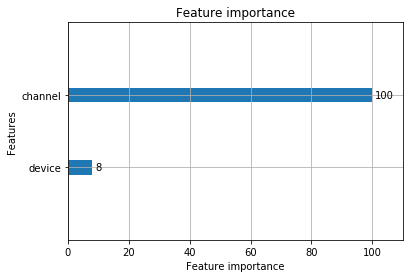

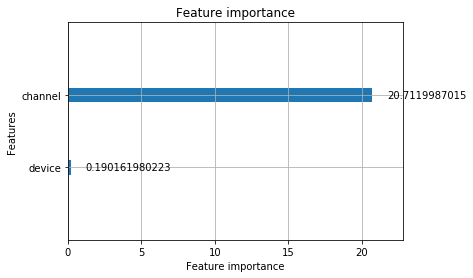

In [25]:
lgb.plot_importance(clf, importance_type='split')
lgb.plot_importance(clf, importance_type='gain')

- error analysys

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10eb53c18>]], dtype=object)

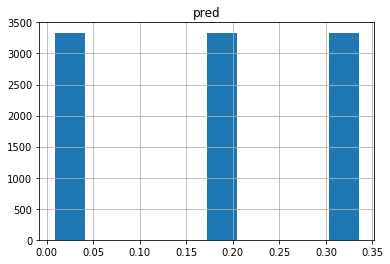

In [26]:
feedback_df.hist(column='pred')

- hard classification

In [29]:
data = pd.concat([x_train, feedback_df], axis=1)

In [31]:
data['target']  = y_train

In [34]:
data[data.target == 1]

,app,device,os,channel,index,pred,target
103,35,1,13,21,103,0.332209,1.0
1504,9,1,22,215,1504,0.184767,1.0
1798,35,1,13,21,1798,0.186747,1.0
2102,35,1,46,274,2102,0.181158,1.0
3056,35,1,13,274,3056,0.331510,1.0
3220,19,0,24,210,3220,0.182855,1.0
3939,72,1,6,101,3939,0.012696,1.0
5282,29,1,41,213,5282,0.335552,1.0
5377,35,1,13,21,5377,0.012696,1.0
5438,19,88,24,213,5438,0.188049,1.0


# save&load用コード

   - ftr

In [ ]:
x_train.to_feather
pd.read_feather

   - lgb data

In [6]:
# train_data.save_binary('lgb_train.bin')
train_data = lgb.Dataset('lgb_train.bin', feature_name=FEAT_NAME, categorical_feature=CAT_FEAT)

In [7]:
clf = lgb.train(all_params,
                        train_data,
                        100,
                            )

/Users/keeeeei/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


- model

In [ ]:
model.save_model(modpath + modfn)
model = lgb.Booster(model_file=modpath + modfn)